In [1]:
import pandas as pd
import glob
import pycountry
import pickle 
import re
from tqdm import tqdm
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora
import spacy
import phrasemachine
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import crossref_commons.retrieval
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
import pingouin as pg

/home/mashrekur/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mashrekur/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mashrekur/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/mashrekur/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the envi

In [ ]:
# # List of all bibtext files
#Return a possibly-empty list of path names that match pathname,
# which must be a string containing a path specification. 
file_list = glob.glob('bibtex_files/**/*.bib')
file_list

In [ ]:
# # Init storage - make a 'list' of columns and create a dataframe with the list 
columns = ['DOI', 'Year', 'Journal', 'Title', 'Abstract', '1st Author Affiliation', 'Country']
corpus_df = pd.DataFrame(columns = columns)

In [ ]:
# # Extract information from all bibtex entries -- store in dataframe

# Loop through bib files
paper_count = -1
for working_file in tqdm(file_list):
    
    # Read bibtex file by line
    with open(working_file) as fp:
        
        # Read first line
        line = fp.readline()
        
        # Loop until end of file
        while line:
            
            # Read active line
            line = fp.readline()
            
            # Find start of a new paper
            if line[:8] == '@article':
                paper_count = paper_count + 1
            
            # Pull components
            if line[:5] == 'Title':
                
#               str.split([separator[, maxsplit]])
                #separator(delimiter)set to double curly brackets
                # At most maxsplit splits are done, list will have maxsplit + 1 elements
                
                title = line.split('{{')[1].split('}}')[0]
                
                #Access a group of rows/columns by label(s)
                #Inside the square brackets, .loc takes two inputs:
                #1 - Row Indexer(paper_count), 2 - Column Indexer(Title,Journal..)
                
                corpus_df.loc[paper_count, 'Title'] = title
                
            if line[:7] == 'Journal':
                journal = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'Journal'] = journal
            if line[:8] == 'Abstract':
                text = line.split('{{')[1].split('\n')[0]
            
                # Read until end of abstract (can be multi-line)
                end_of_abstract = False
                while not end_of_abstract:
                    line = fp.readline()
                    if len(line.split('}}')) == 1:
                        text = text + line.split('}}')[0].split('\n')[0]
                    else:
                        text = text + line.split('}}')[0].split('\n')[0]
                        end_of_abstract = True
                corpus_df.loc[paper_count, 'Abstract'] = text

            if line[:3] == 'DOI':
                doi = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'DOI'] = doi
                     
            if line[:4] == 'Year':
                year = line.split('{{')[1].split('}}')[0]
                corpus_df.loc[paper_count, 'Year'] = year
            if line[:17] == 'Early Access Date':
                year = line.split('{{')[1].split('}}')[0][-4:]
                corpus_df.loc[paper_count, 'Year'] = year
            
            if line[:11] == 'Affiliation':
                affiliation = line.split()
                affiliation2 = (affiliation[-1:][0]).split('.')[0]
                corpus_df.loc[paper_count, '1st Author Affiliation'] = affiliation
                corpus_df.loc[paper_count, 'Country'] = affiliation2

    # Close file
    fp.close()

In [ ]:
#Returns uniques in order of appearance
corpus_df['Journal'].unique()

In [ ]:
# Change journal names to abbreviations
journal_abbreviations = {'Water Resour. Res.':'WRR', 'Hydrol. Process.':'HP',
       'Hydrol. Sci. J.-J. Sci. Hydrol.':'HSJ', 'J. Hydrometeorol.':'JHM',
       'J. Hydrol.':'JH', 'Adv. Water Resour.':'AWR', 'Hydrol. Earth Syst. Sci.':'HESS',
       'Hydrogeol. J.':'HGJ', 'J. Am. Water Resour. Assoc.':'JAWRA', 'J. Contam. Hydrol.':'JCH','J. Water Resour. Plan. Manage.-ASCE':'JWRPM',
       'Water Res.':'WR', 'Water Resour. Manag.':'WRM','Environ. Sci.-Wat. Res. Technol.':'ESWRT','Int. Soil Water Conserv. Res.':'ISWCR','J. Hydrol.-Reg. Stud.':'JHREG','Water Resour. Ind.':'WRI', 'Ground Water':'GW'}
# replace values with other values
corpus_df['Journal'].replace(journal_abbreviations, inplace=True)

In [ ]:
#order dataframe according to timestamps
# corpus_df.sort_values(by=['Year'], inplace=True, ascending=True)

#remove NaN abstracts
corpus_df = corpus_df[corpus_df['Abstract'].notna()]

#resetting index; drop empty rows
corpus_df.reset_index(drop=True)

In [2]:
# # load preprocessed corpus for original static topic model
with open('data/raw_corpus_broad_country.pkl', 'rb') as f:
    corpus_df = pickle.load(f)

In [3]:
# corpus_df.loc[corpus_df['Country'] == '02139']['1st Author Affiliation']

In [4]:
corpus_df['Country'][2][-6:] == 'CANADA'

False

In [5]:
# for c, country in enumerate(corpus_df['Country']):
#     if corpus_df['Country'][-6:] == 'CANADA':
#         print(corpus_df['Country'][c])
        

In [6]:
corpus_df['Country'] = np.where((corpus_df['Country'] == '560012,KARNATAKA,INDIA'), 'India', corpus_df['Country'])


In [7]:
country_df = pd.DataFrame(corpus_df['Country'].value_counts()[0:40])

In [8]:
country_dict = pd.DataFrame.to_dict(country_df)
country_dict
4328/74479*100

5.811033982733388

In [9]:
# Save the dataframe
corpus_df.to_pickle("data/raw_corpus_broad_country.pkl")

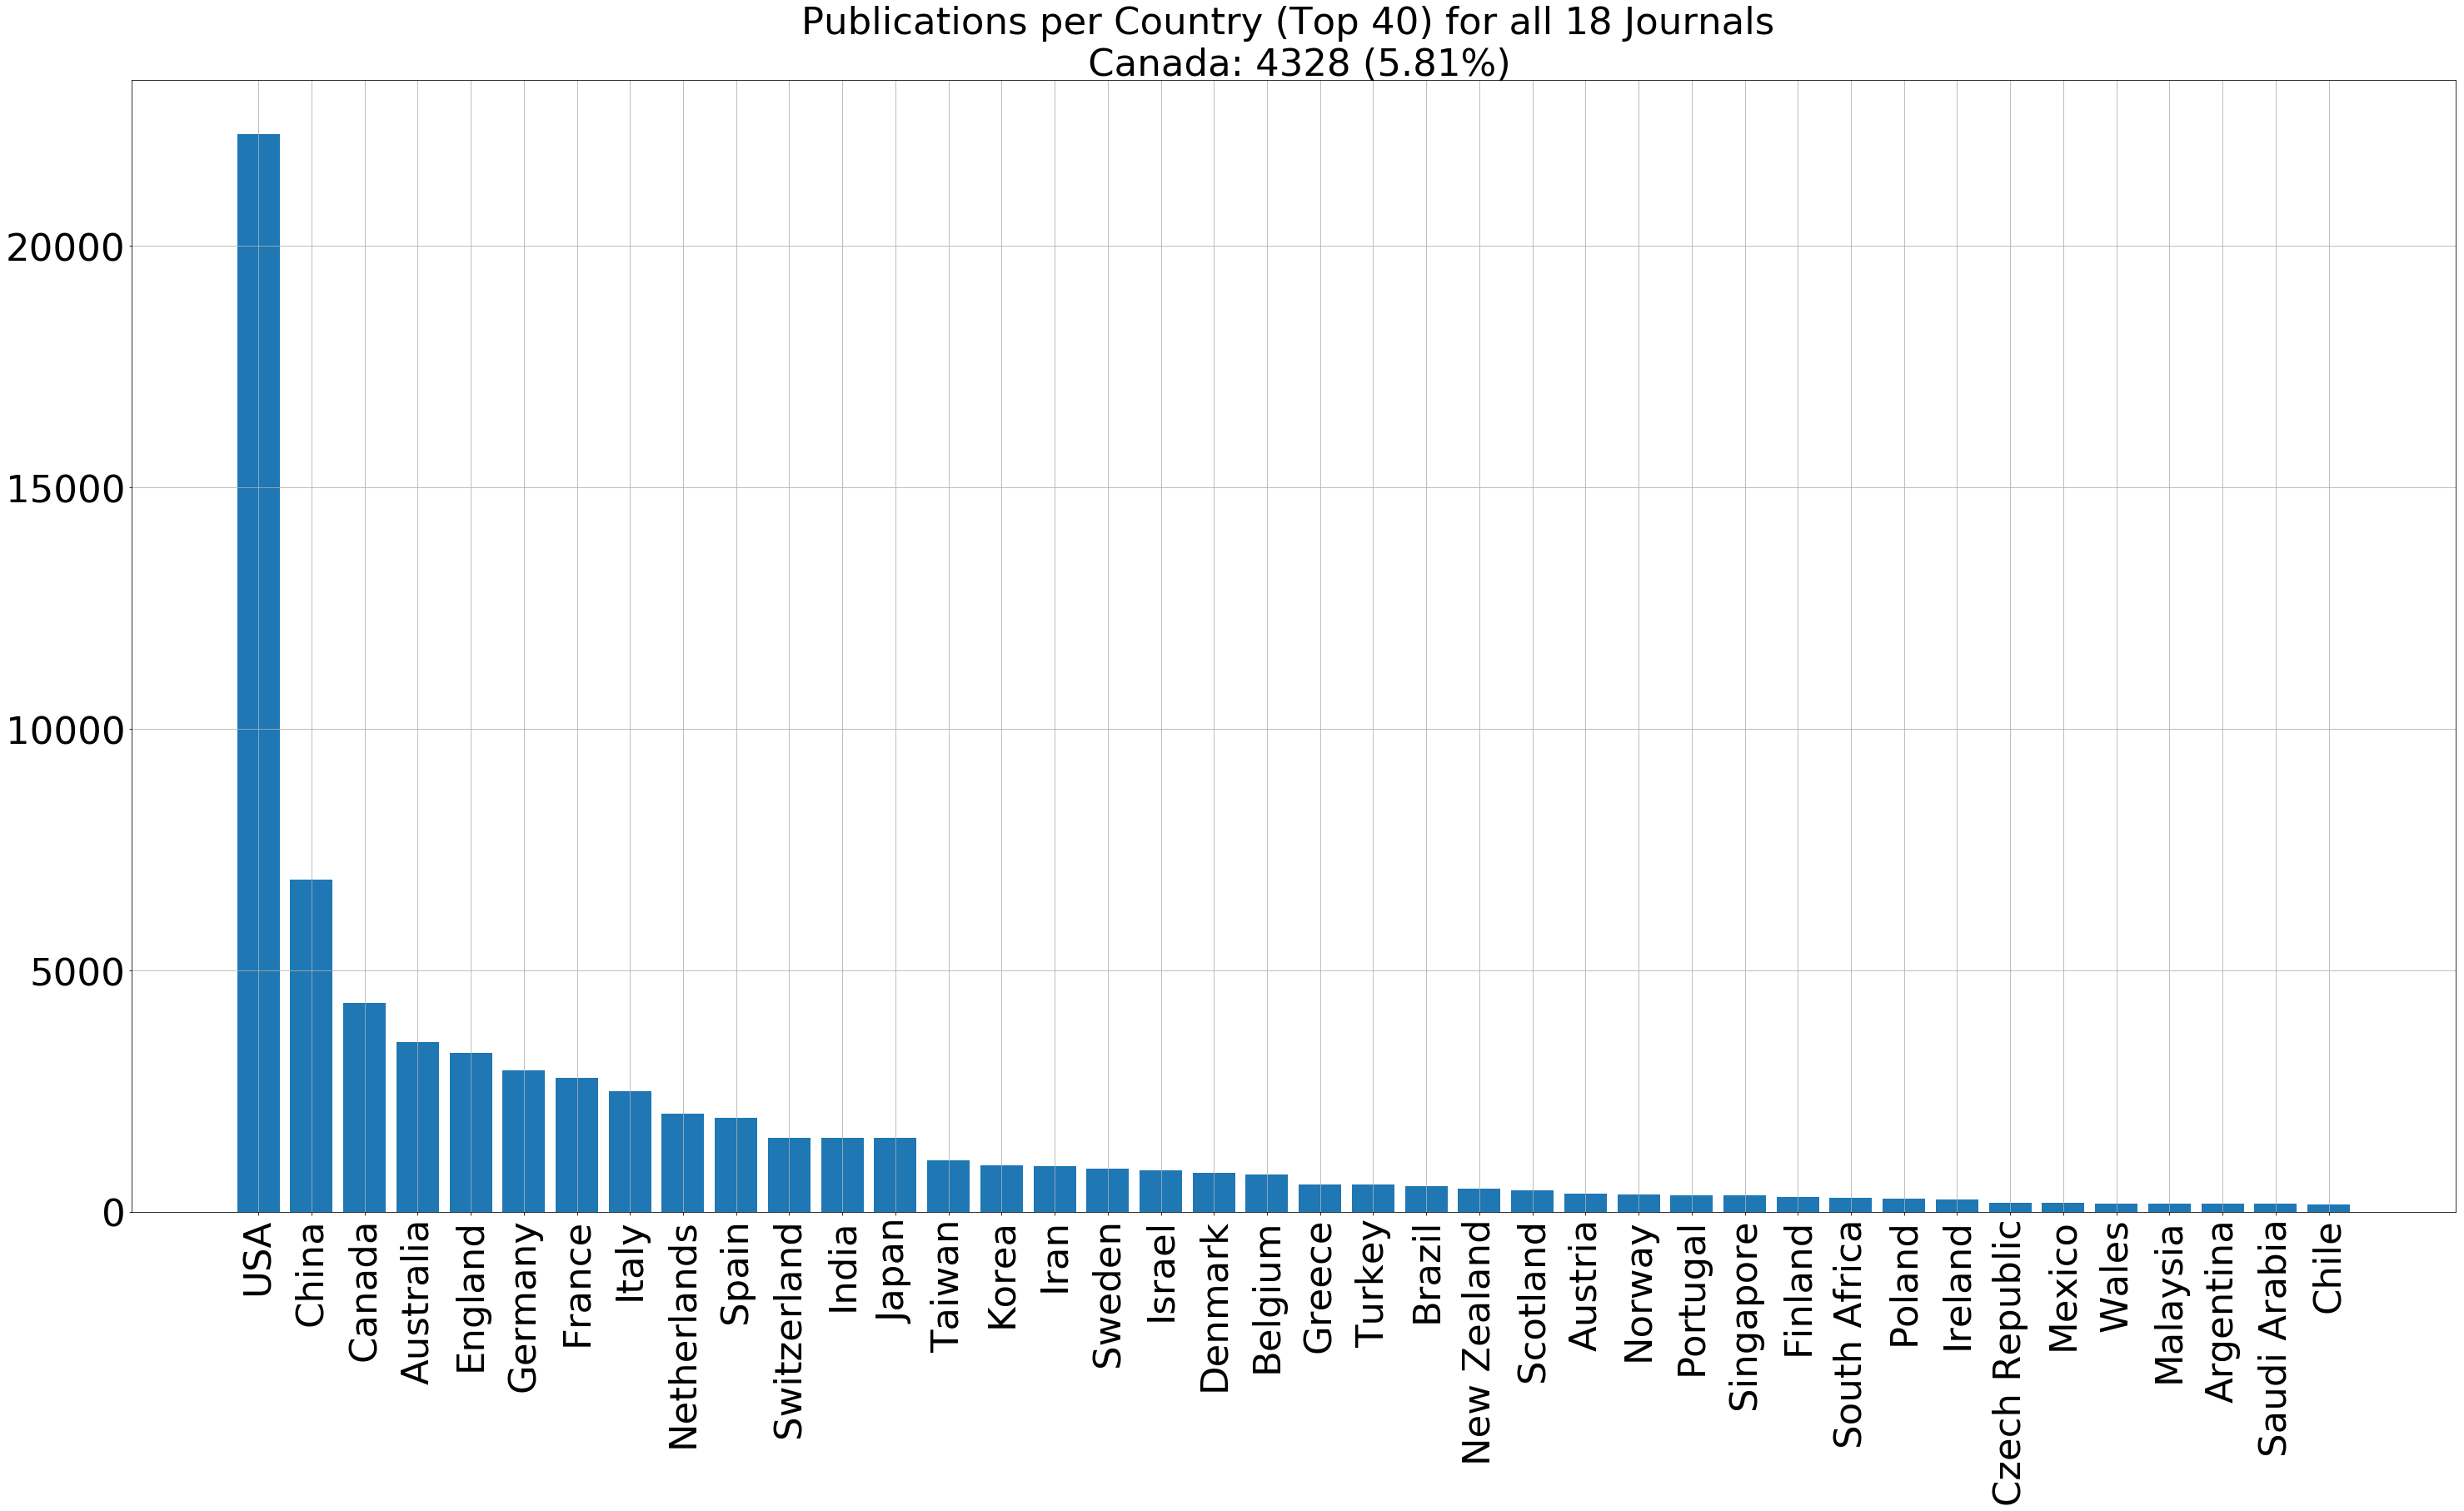

<Figure size 432x288 with 0 Axes>

In [10]:
f, ax = plt.subplots(figsize=(50,25))
plt.bar(country_dict['Country'].keys(), country_dict['Country'].values())
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.title('Publications per Country (Top 40) for all 18 Journals \n Canada: 4328 (5.81%)', size = 45)
plt.grid()
plt.show()
plt.savefig('figures/litmin_country_all_barplot')

In [11]:
canada_dict = pd.Series.to_dict(corpus_df[corpus_df['Country'] == 'Canada']['Year'].value_counts(ascending = True))
canada_dict = sorted(canada_dict.items())
canada_df = pd.DataFrame(canada_dict)
canada_df[1][0]

35

In [12]:
all_dict = pd.Series.to_dict(corpus_df['Year'].value_counts(ascending = True))
all_dict = sorted(all_dict.items())
all_df = pd.DataFrame(all_dict)


In [13]:
years = np.unique(corpus_df['Year'])
frac_list = []
for y in range(0,len(years)-1,1):
    a = canada_df[1][y]
    b = all_df[1][y]
    frac = a/b
    frac_list.append(frac)
frac_list

[0.04232164449818621,
 0.03691983122362869,
 0.045845272206303724,
 0.04186046511627907,
 0.048467569493941556,
 0.06402877697841726,
 0.03783102143757881,
 0.06287069988137604,
 0.06600467289719626,
 0.074877916440586,
 0.0644122383252818,
 0.0545361875637105,
 0.05771050141911069,
 0.057547169811320756,
 0.061361457334611694,
 0.07467532467532467,
 0.05886681383370125,
 0.0595956012770486,
 0.06334371754932502,
 0.06384408602150538,
 0.06025236593059937,
 0.05479059093516925,
 0.053406998158379376,
 0.059555772516475466,
 0.06491646778042959,
 0.059547794940676066,
 0.053821800090456805,
 0.05299032541776605,
 0.054820415879017016]

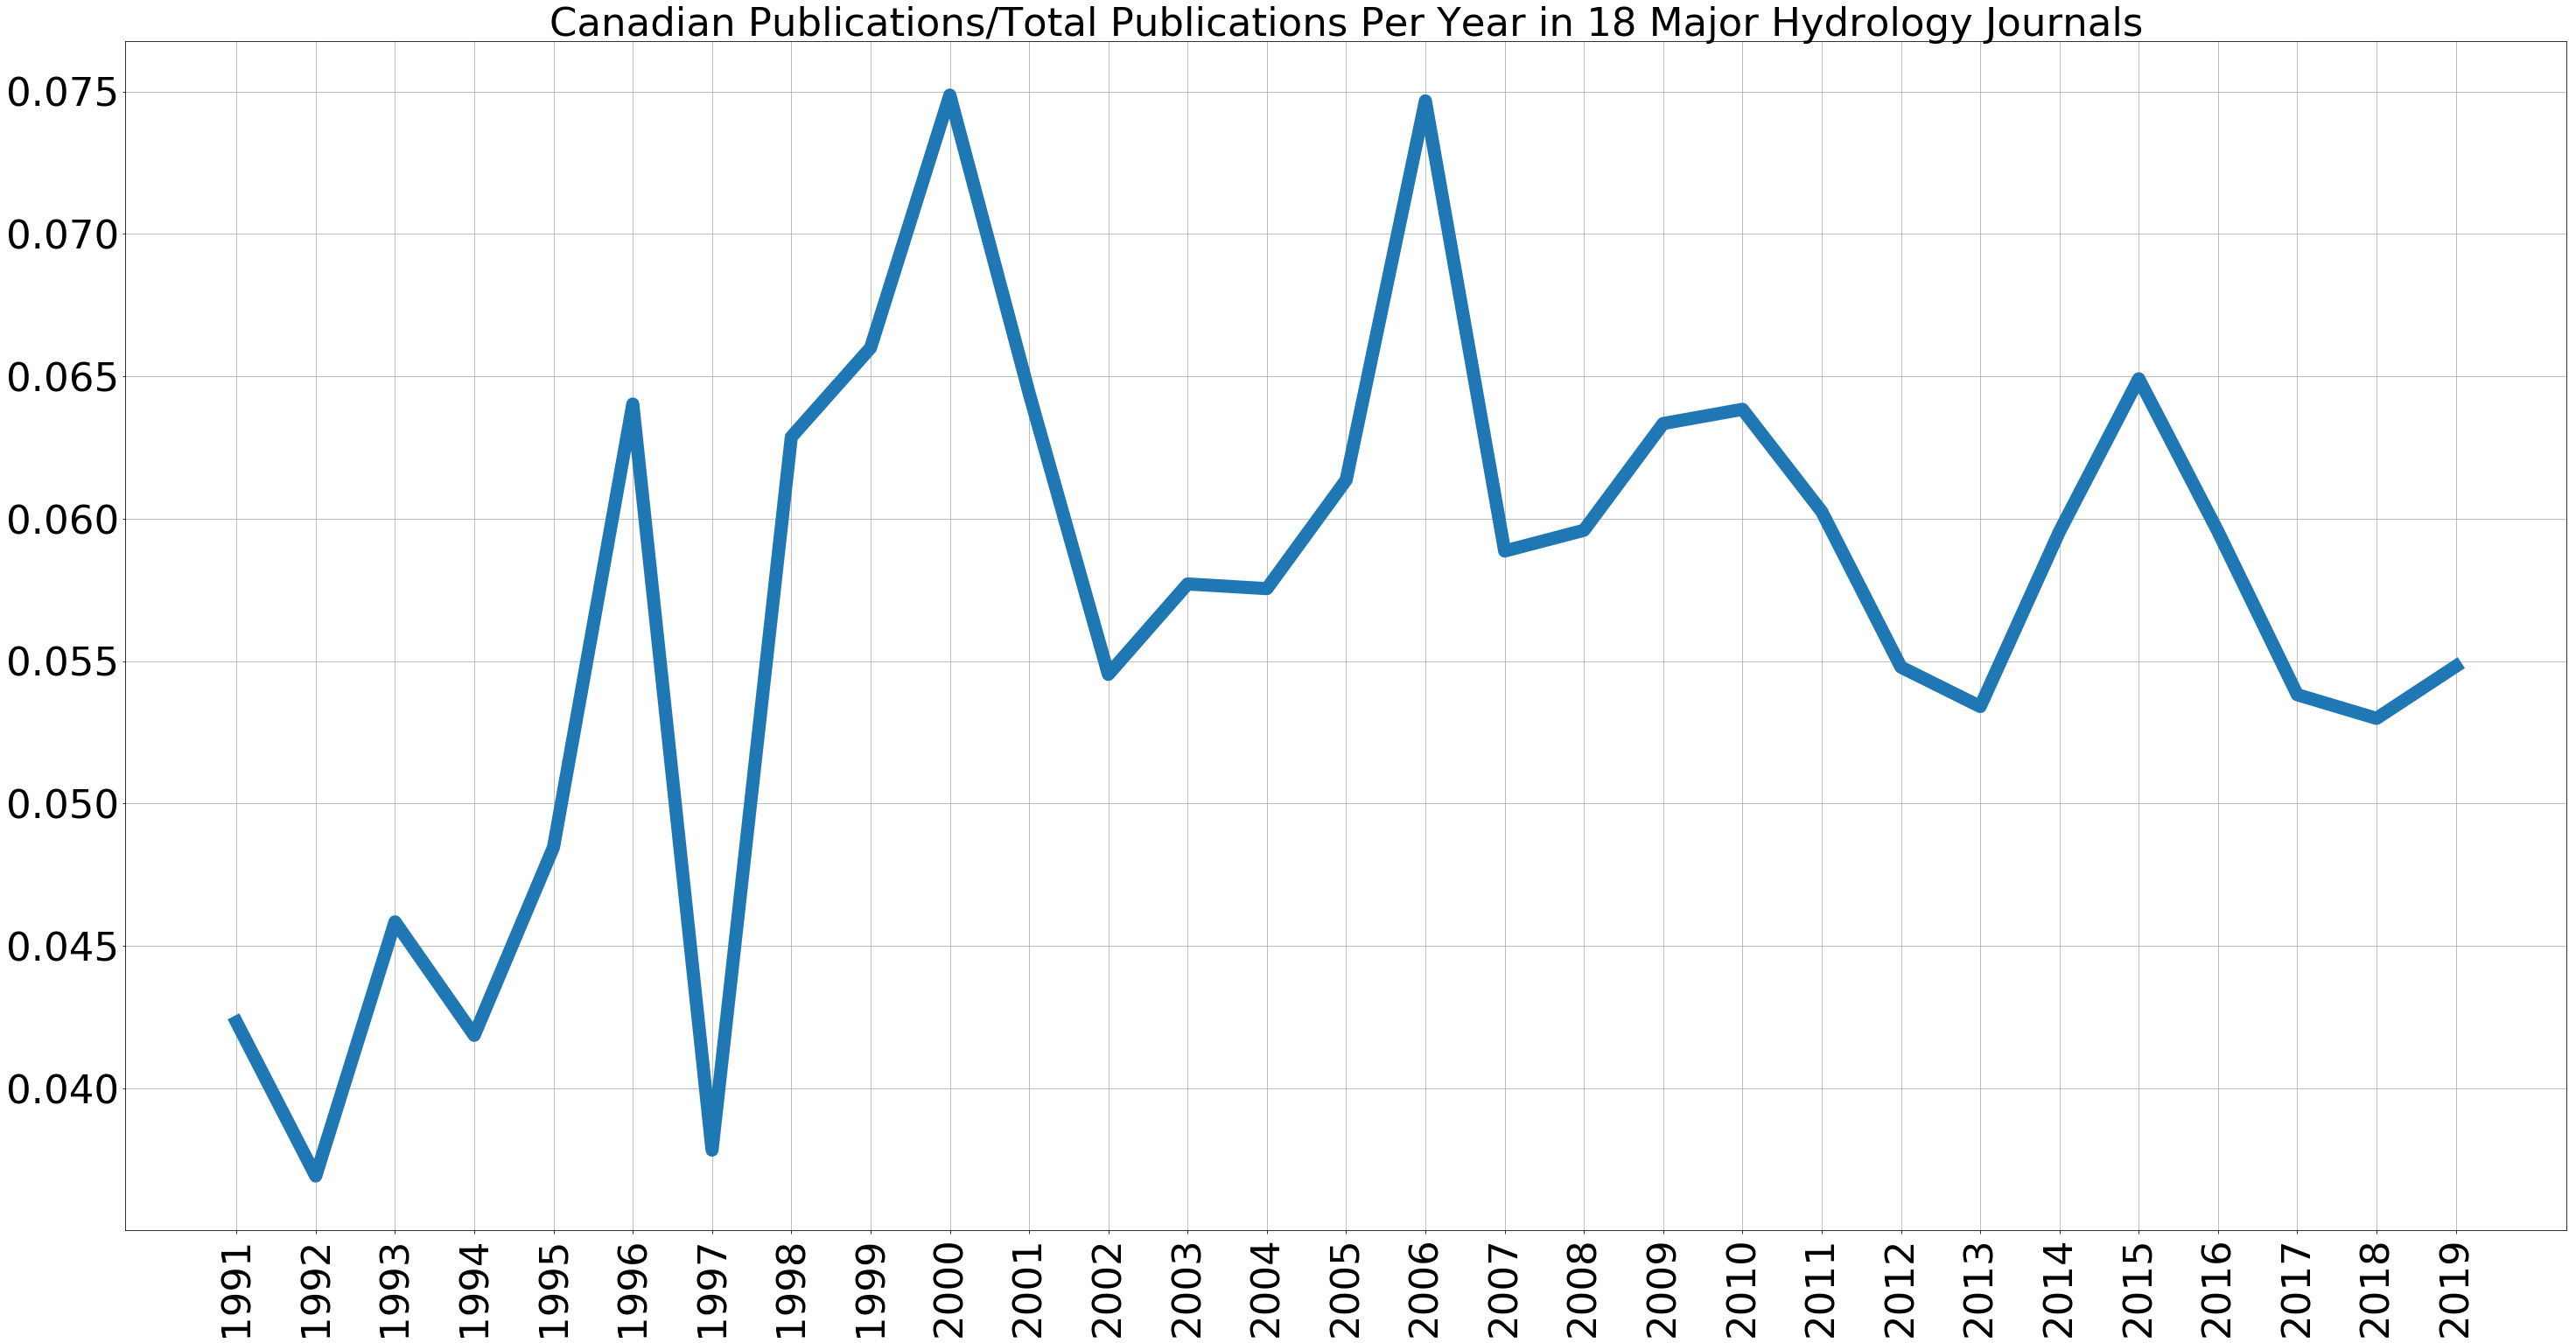

<Figure size 432x288 with 0 Axes>

In [14]:
f, ax = plt.subplots(figsize=(50,25))
plt.plot(years[:-1],frac_list, linewidth = 15)
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.title('Canadian Publications/Total Publications Per Year in 18 Major Hydrology Journals', size = 45)
plt.grid()
plt.show()
plt.savefig('figures/litmin_canada_frac_trend_18journals')

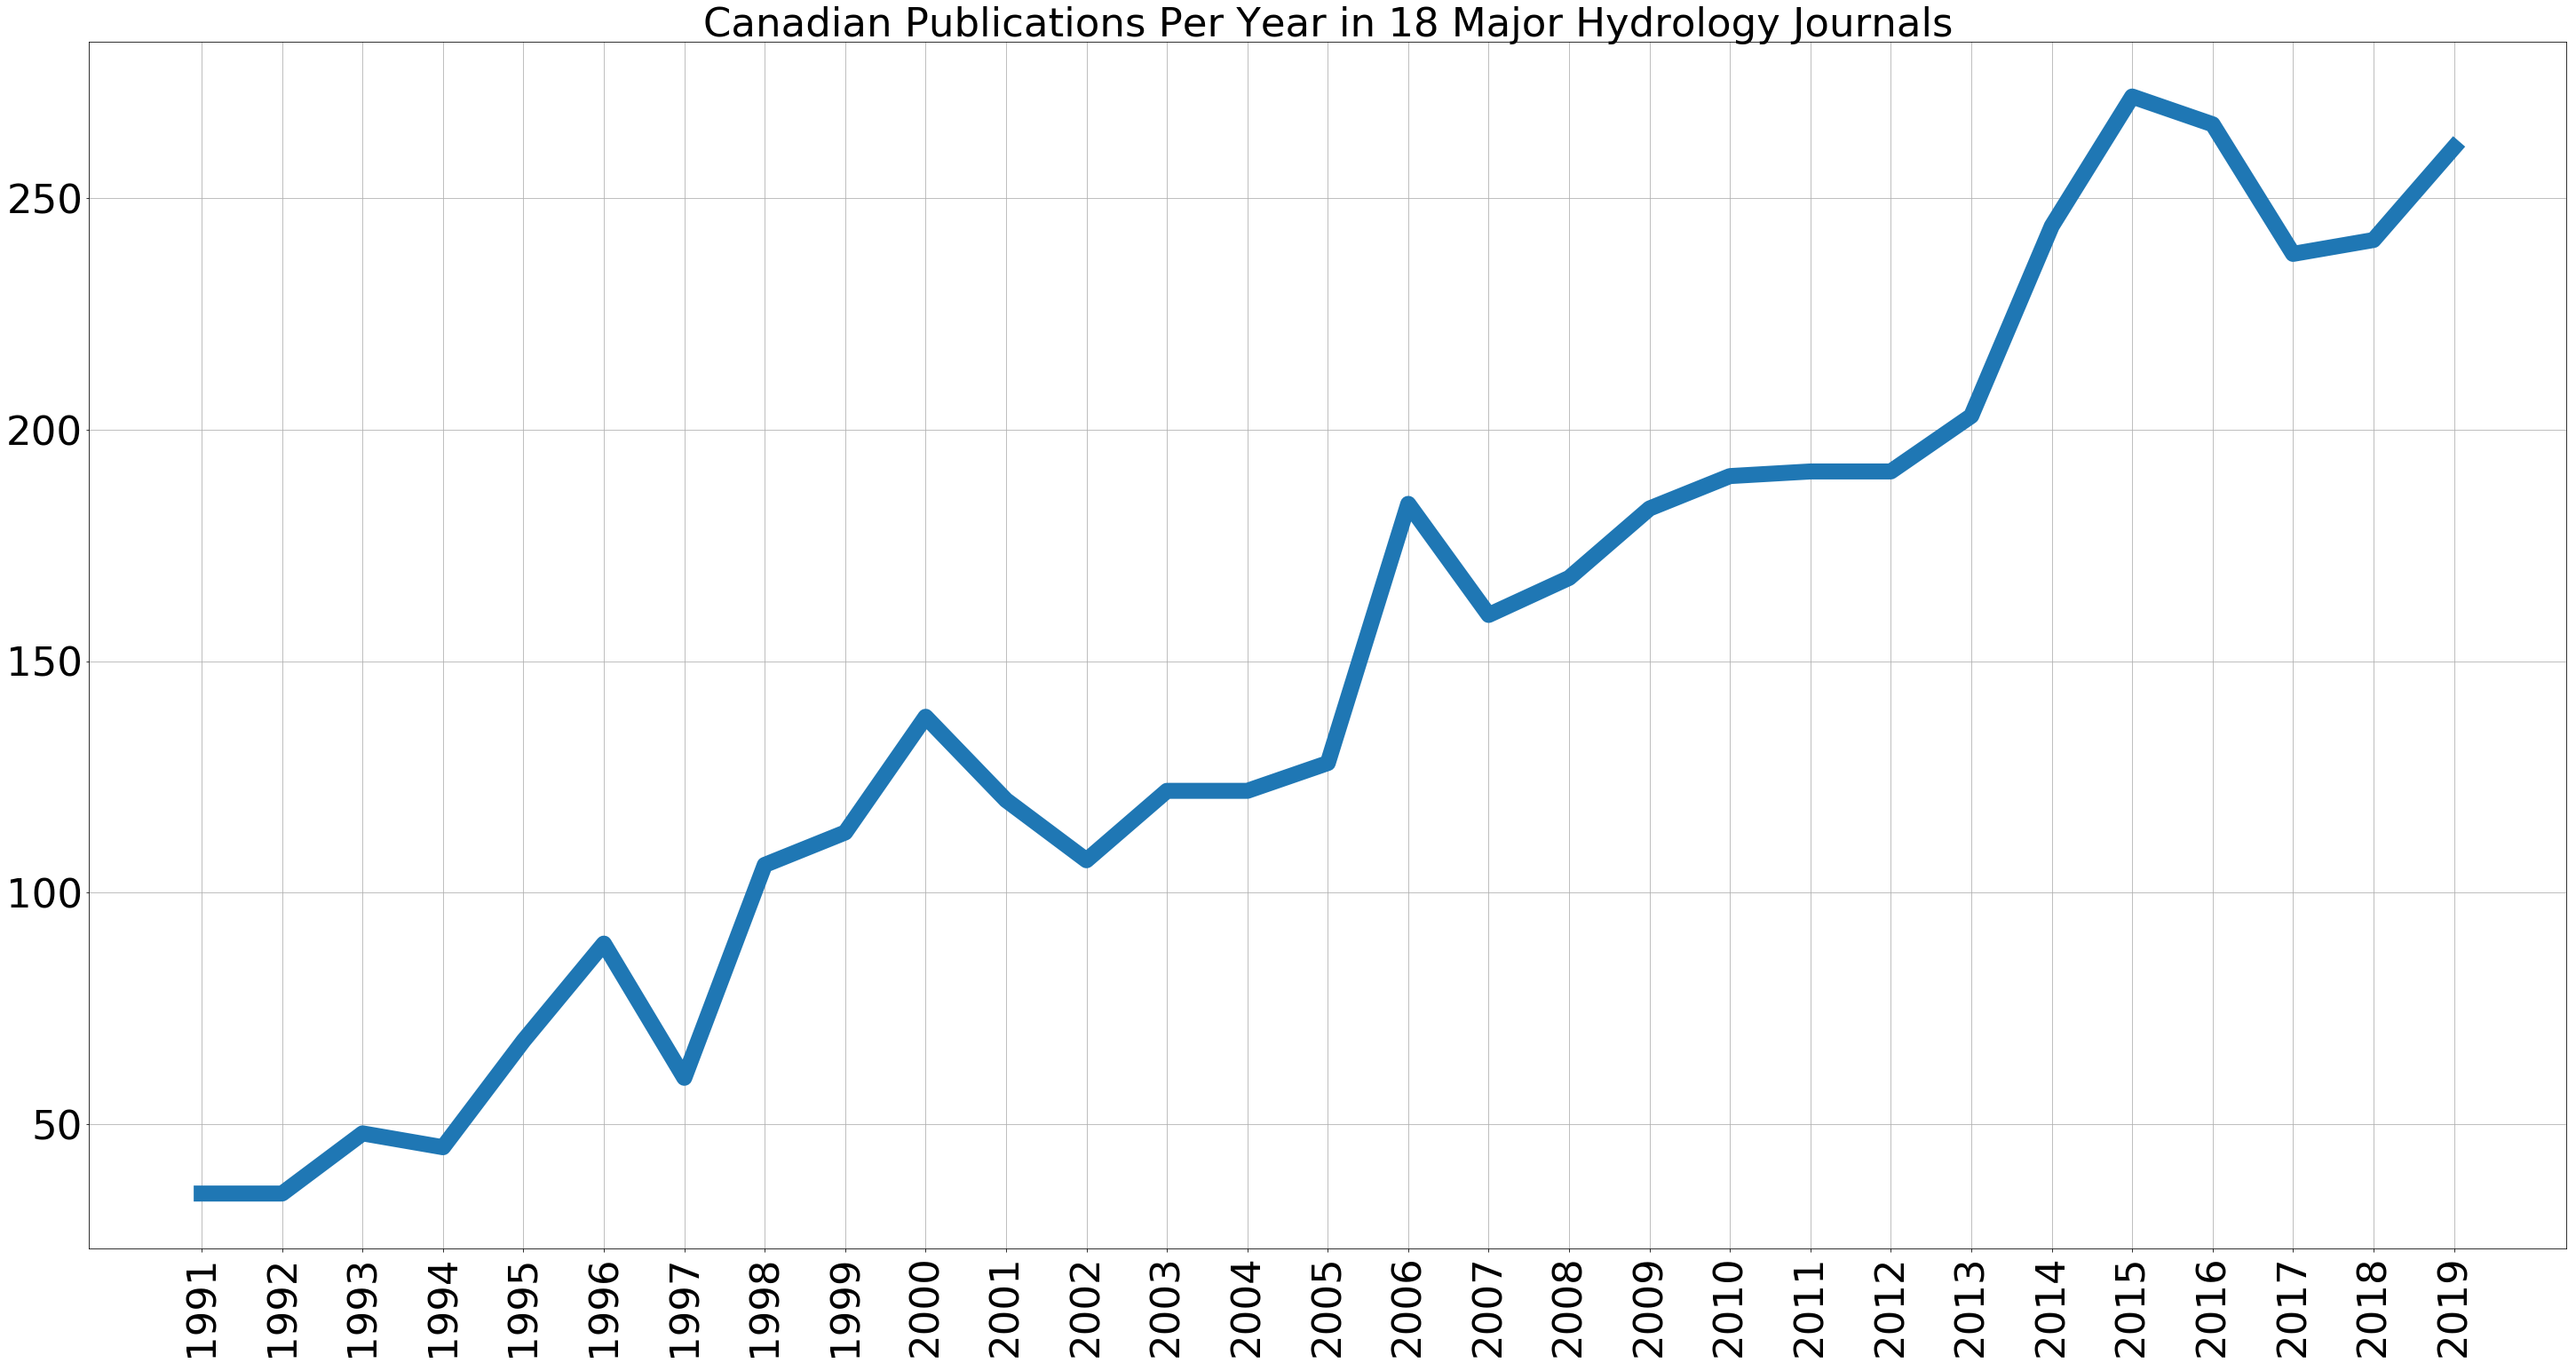

<Figure size 432x288 with 0 Axes>

In [15]:
f, ax = plt.subplots(figsize=(50,25))
plt.plot(canada_df[0],canada_df[1],linewidth = 18)
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.title('Canadian Publications Per Year in 18 Major Hydrology Journals', size = 45)
plt.grid()
plt.show()
plt.savefig('figures/litmin_canada_trend_18journals')


In [16]:
#Statistical trend analysis for canadian publications
y_list = [*range(0, 29, 1)]
print('Statistical Trend Analysis for the Number of Canadian publications Per Year in 18 Journals')
pg.corr(np.array(y_list),np.array(canada_df[1]))

Statistical Trend Analysis for the Number of Canadian publications Per Year in 18 Journals


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,29,0.973812,"[0.94, 0.99]",0.948311,0.944334,6.666126e-19,3.264e+15,1.0


In [17]:
#Statistical trend analysis for canadian publications as a fraction of total publications
y_list = [*range(0, 29, 1)]
print('Statistical Trend Analysis on the Number of Canadian publications \n as a Fraction of the Total Publications Per Year in the 18 Journals')
pg.corr(np.array(y_list),np.array(frac_list))

Statistical Trend Analysis on the Number of Canadian publications 
 as a Fraction of the Total Publications Per Year in the 18 Journals


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,29,0.356673,"[-0.01, 0.64]",0.127216,0.060078,0.057531,1.288,0.488181


/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/mashrekur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


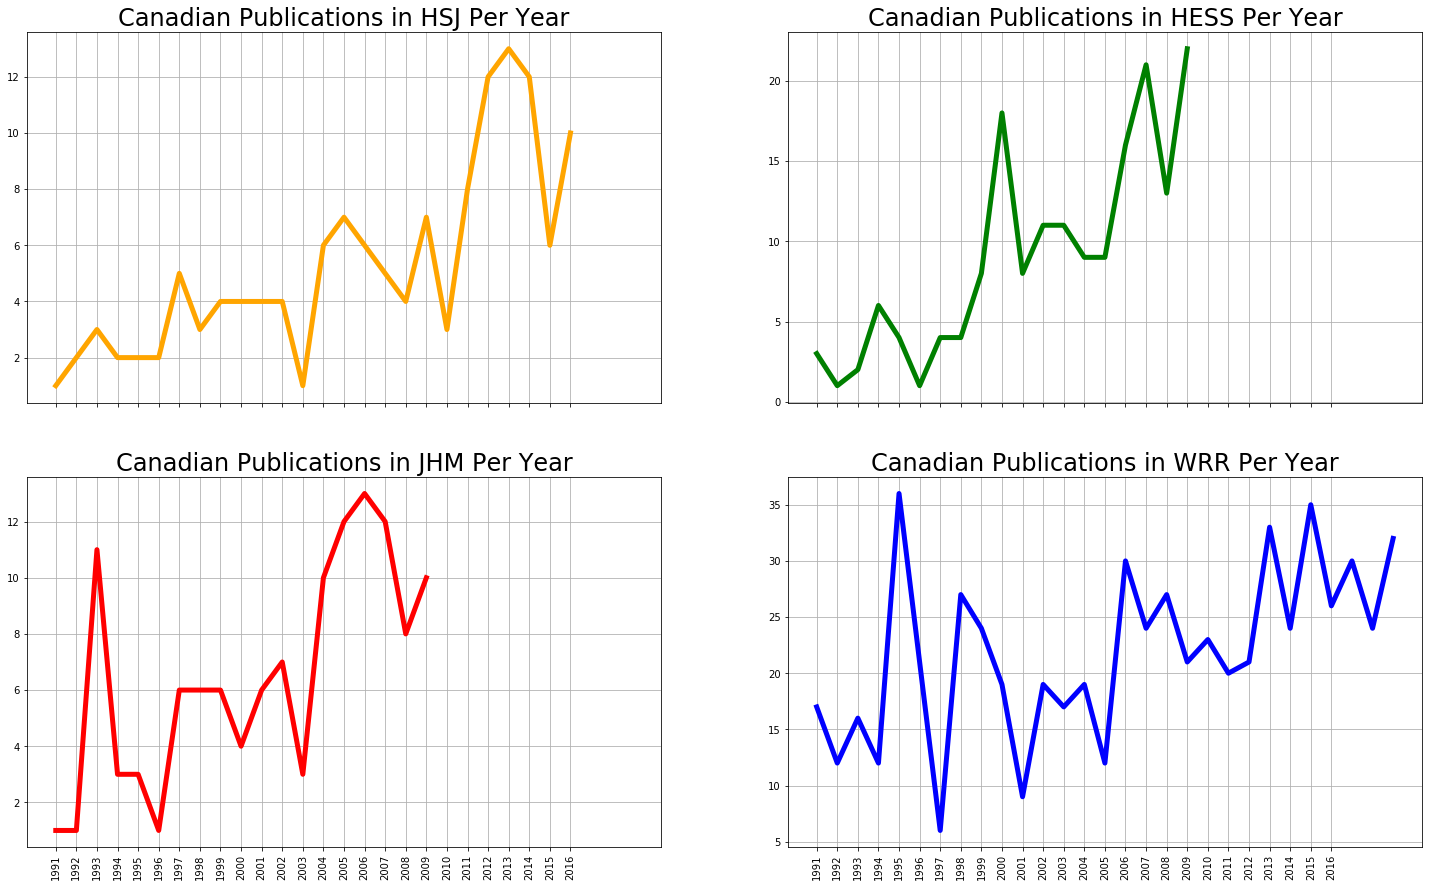

In [18]:
#plot for canadian publications in the four journals
is_wrr = corpus_df['Journal'] == 'WRR'
is_hess = corpus_df['Journal'] == 'HESS'
is_jhm = corpus_df['Journal'] == 'JHM'
is_hsj = corpus_df['Journal'] == 'HSJ'
is_canada = corpus_df['Country'] == 'Canada'

wrr_canada_dict = pd.Series.to_dict(corpus_df[is_wrr][is_canada]['Year'].value_counts(ascending = True))
wrr_canada_dict = sorted(wrr_canada_dict.items())
wrr_canada_df = pd.DataFrame(wrr_canada_dict)

hess_canada_dict = pd.Series.to_dict(corpus_df[is_hess][is_canada]['Year'].value_counts(ascending = True))
hess_canada_dict = sorted(hess_canada_dict.items())
hess_canada_df = pd.DataFrame(hess_canada_dict)

jhm_canada_dict = pd.Series.to_dict(corpus_df[is_jhm][is_canada]['Year'].value_counts(ascending = True))
jhm_canada_dict = sorted(jhm_canada_dict.items())
jhm_canada_df = pd.DataFrame(jhm_canada_dict)

hsj_canada_dict = pd.Series.to_dict(corpus_df[is_hsj][is_canada]['Year'].value_counts(ascending = True))
hsj_canada_dict = sorted(hsj_canada_dict.items())
hsj_canada_df = pd.DataFrame(hsj_canada_dict)


fig, axs = plt.subplots(2,2,figsize=(25,15),sharex=True,sharey = False)


axs[1, 1].plot(wrr_canada_df[0], wrr_canada_df[1], color = 'blue', label = 'WRR',linewidth = 5)
axs[1, 1].set_title('Canadian Publications in WRR Per Year',size=24)
axs[1, 1].set_xticklabels(years,rotation = 90)
axs[1, 1].grid()

axs[0, 1].plot(hess_canada_df[0], hess_canada_df[1], color = 'green', label = 'HESS',linewidth = 5)
axs[0, 1].set_title('Canadian Publications in HESS Per Year',size=24)
axs[0, 1].set_xticklabels(years,rotation = 90)
axs[0, 1].grid()

axs[1, 0].plot(jhm_canada_df[0], jhm_canada_df[1], color = 'red', label = 'JHM',linewidth = 5)
axs[1, 0].set_title('Canadian Publications in JHM Per Year',size=24)
axs[1, 0].set_xticklabels(years,rotation = 90)
axs[1, 0].grid()

axs[0, 0].plot(hsj_canada_df[0], hsj_canada_df[1], color = 'orange', label = 'HSJ',linewidth = 5)
axs[0, 0].set_title('Canadian Publications in HSJ Per Year',size=24)
axs[0, 0].set_xticklabels(years,rotation = 90)
axs[0, 0].grid()


plt.savefig('figures/litmin_canada_trend_4_journals')


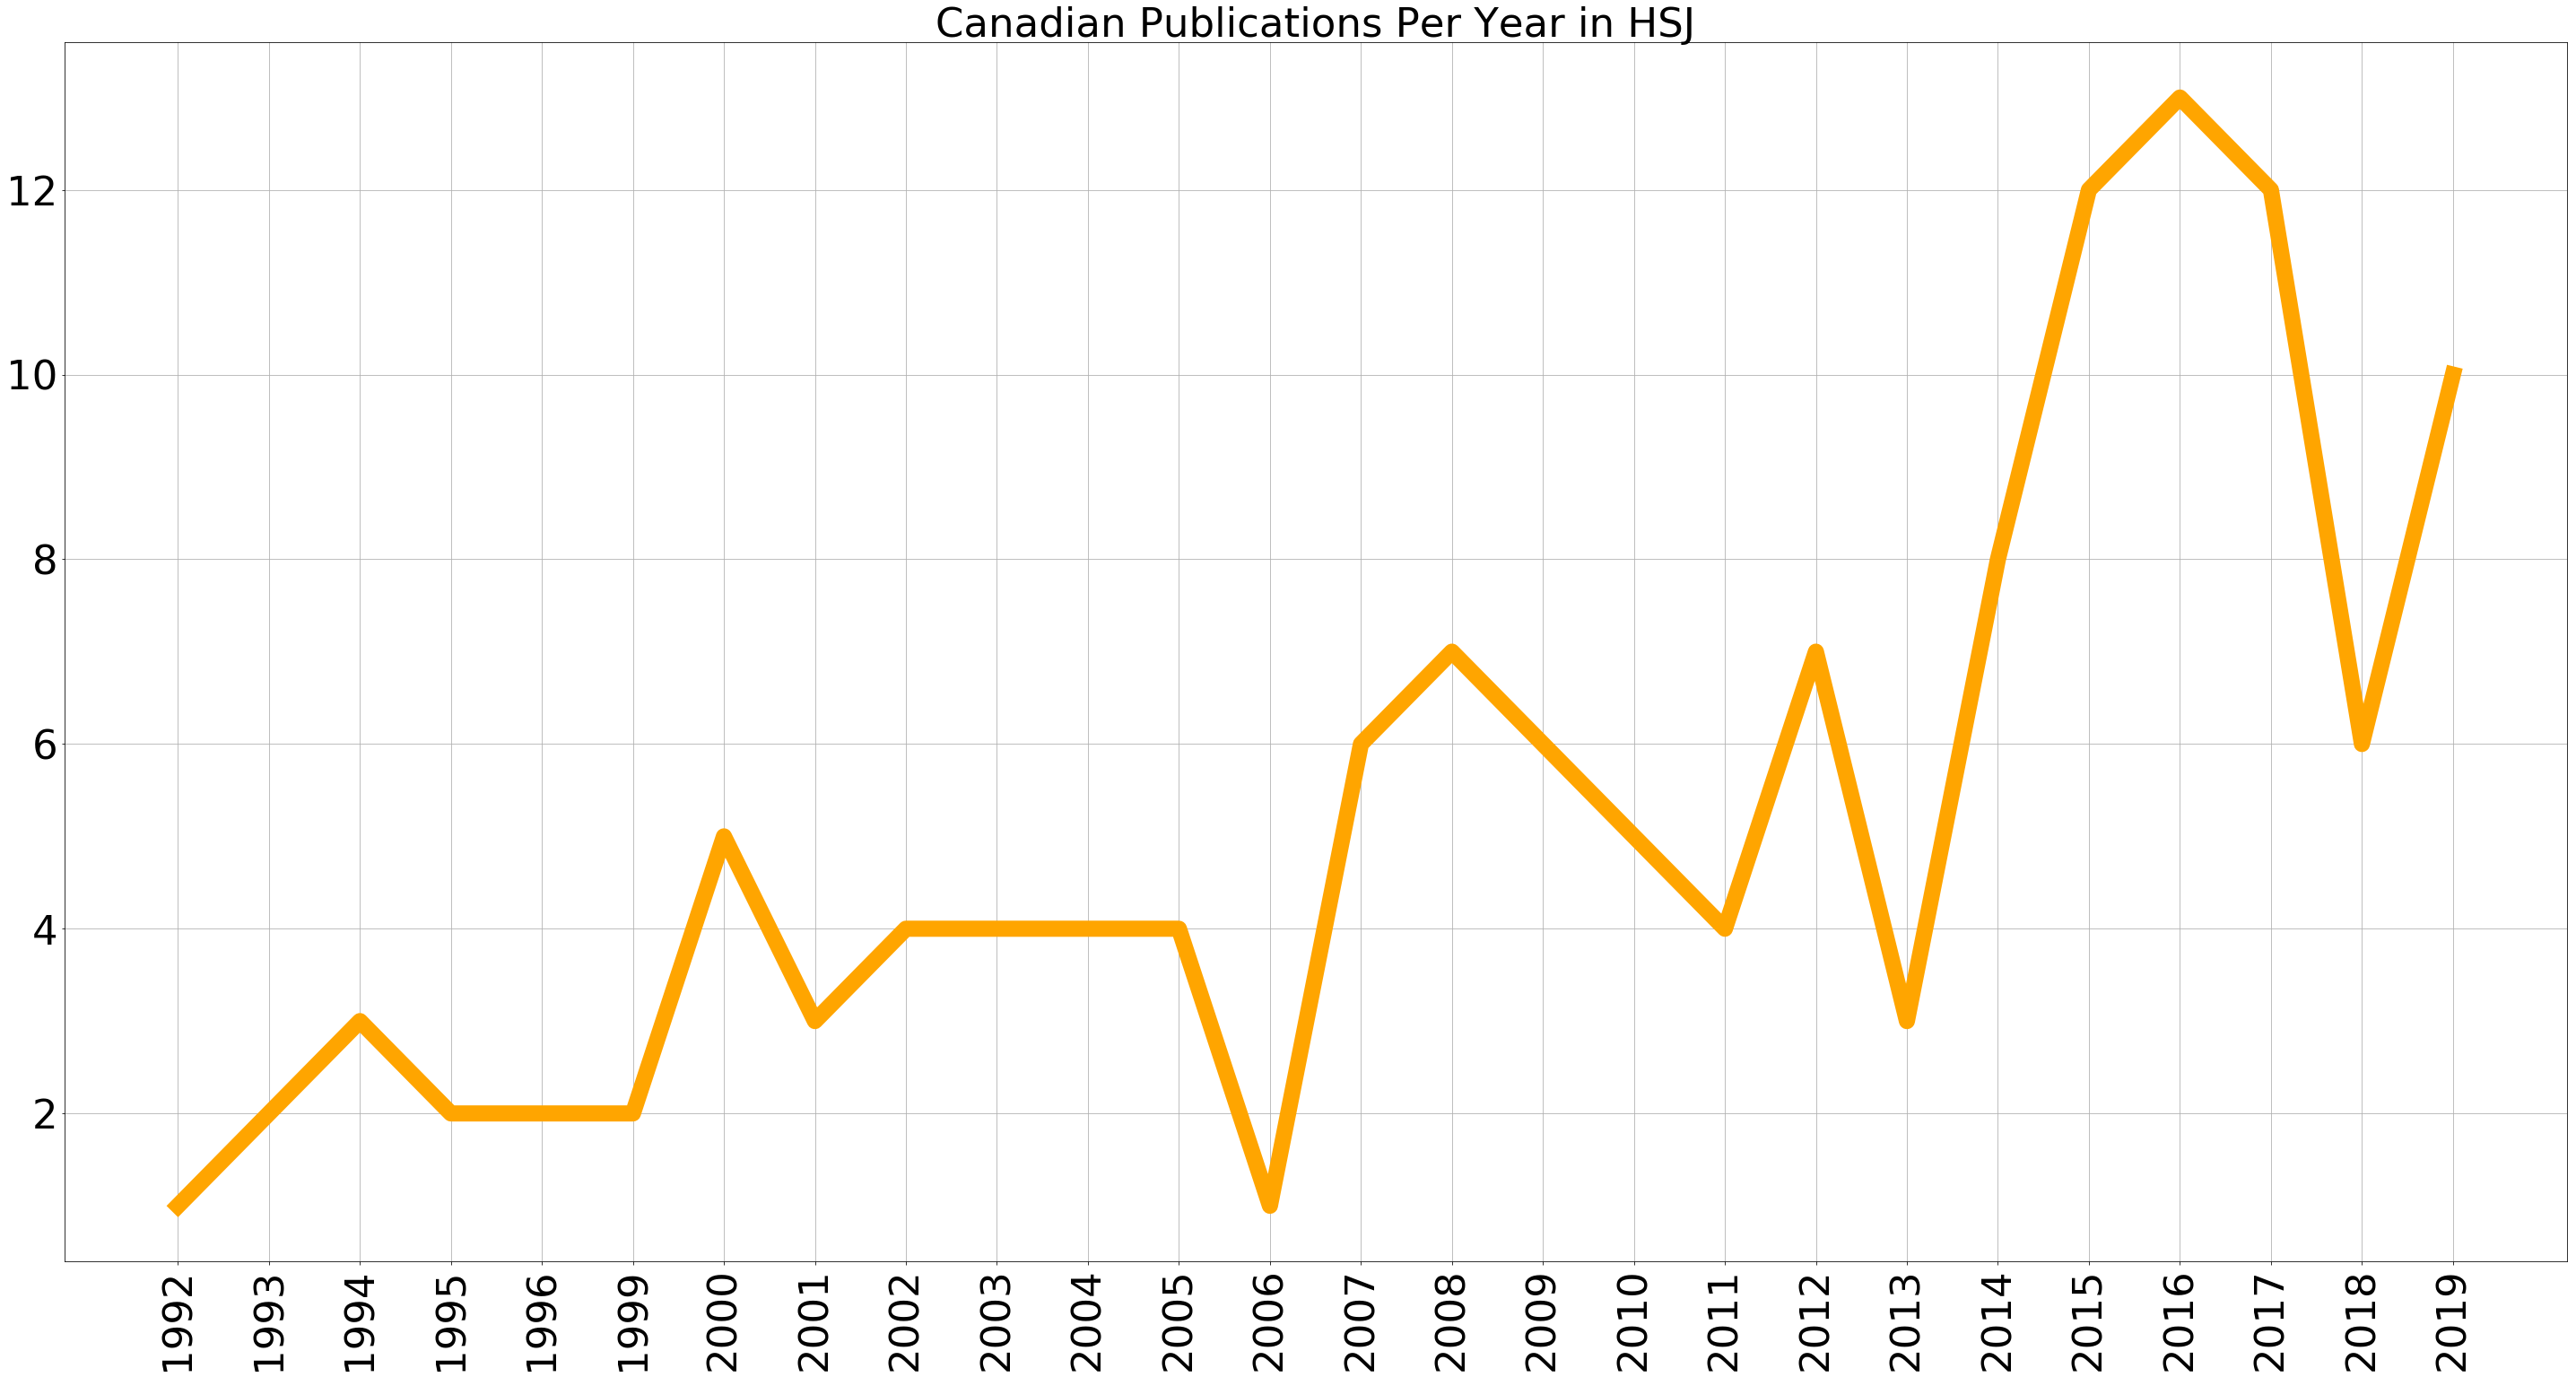

In [19]:
f, ax = plt.subplots(figsize=(50,25))
plt.plot(hsj_canada_df[0],hsj_canada_df[1],linewidth = 18, color = 'Orange')
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.title('Canadian Publications Per Year in HSJ', size = 45)
plt.grid()
plt.show()

In [20]:
#Extract the unique years for canadian publications in each journal
year_wrr_canada = np.unique(corpus_df['Year'][is_wrr][is_canada])
year_hess_canada = np.unique(corpus_df['Year'][is_hess][is_canada])
year_jhm_canada = np.unique(corpus_df['Year'][is_jhm][is_canada])
year_hsj_canada = np.unique(corpus_df['Year'][is_hsj][is_canada])

In [ ]:
#Extracting the global counts per journal per year
global_count_wrr = {}
global_count_hess = {}
global_count_jhm = {}
global_count_hsj = {}

for y, year in enumerate(year_wrr_canada):
    global_count_wrr[year] = corpus_df[corpus_df['Year'] == year][is_wrr]['Year'].value_counts()[0]

for y, year in enumerate(year_hess_canada):
    global_count_hess[year] = corpus_df[corpus_df['Year'] == year][is_hess]['Year'].value_counts()[0]

for y, year in enumerate(year_jhm_canada):
    global_count_jhm[year] = corpus_df[corpus_df['Year'] == year][is_jhm]['Year'].value_counts()[0]    

for y, year in enumerate(year_hsj_canada):
    global_count_hsj[year] = corpus_df[corpus_df['Year'] == year][is_hsj]['Year'].value_counts()[0]

In [ ]:
# corpus_df[corpus_df['Year'] == '2001'][is_hess]['Year'].value_counts()[0]

In [ ]:
#Plot for wrr
wrr_year_dict = pd.Series.to_dict(corpus_df['Year'][is_wrr].value_counts(ascending = True))
wrr_year_dict = sorted(wrr_year_dict.items())
wrr_year_df = pd.DataFrame(wrr_year_dict)

frac_list = []
for y, year in enumerate(year_wrr_canada):
    a = wrr_canada_df[1][y]
    b = global_count_wrr[year]
    frac = (a/b)*100
    frac_list.append(frac)


f, ax = plt.subplots(figsize=(50,25))
plt.plot(year_wrr_canada,frac_list, linewidth = 15,  color = 'blue')
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.ylabel('Percentage (%) of Canadian Publications', size = 45)
plt.title('Percentage of Canadian Publications in Global Publications Per Year for WRR', size = 45)
plt.grid()
plt.show()

In [ ]:
#Plot for hess
hess_year_dict = pd.Series.to_dict(corpus_df['Year'][is_hess].value_counts(ascending = True))
hess_year_dict = sorted(hess_year_dict.items())
hess_year_df = pd.DataFrame(hess_year_dict)

frac_list = []
for y, year in enumerate(year_hess_canada):
    a = hess_canada_df[1][y]
    b = global_count_hess[year]
    frac = (a/b)*100
    frac_list.append(frac)


f, ax = plt.subplots(figsize=(50,25))
plt.plot(year_hess_canada,frac_list, linewidth = 15,  color = 'green')
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.ylabel('Percentage (%) of Canadian Publications', size = 45)
plt.title('Percentage of Canadian Publications in Global Publications Per Year for HESS', size = 45)
plt.grid()
plt.show()


In [ ]:
jhm_year_dict = pd.Series.to_dict(corpus_df['Year'][is_jhm].value_counts(ascending = True))
jhm_year_dict = sorted(jhm_year_dict.items())
jhm_year_df = pd.DataFrame(jhm_year_dict)

frac_list = []
for y, year in enumerate(year_jhm_canada):
    a = jhm_canada_df[1][y]
    b = global_count_jhm[year]
    frac = (a/b)*100
    frac_list.append(frac)


f, ax = plt.subplots(figsize=(50,25))
plt.plot(year_jhm_canada,frac_list, linewidth = 15,  color = 'Red')
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.ylabel('Percentage (%) of Canadian Publications', size = 45)
plt.title('Percentage of Canadian Publications in Global Publications Per Year for JHM', size = 45)
plt.grid()
plt.show()

In [ ]:
hsj_year_dict = pd.Series.to_dict(corpus_df['Year'][is_hsj].value_counts(ascending = True))
hsj_year_dict = sorted(hsj_year_dict.items())
jhm_year_df = pd.DataFrame(hsj_year_dict)

frac_list = []
for y, year in enumerate(year_hsj_canada):
    a = hsj_canada_df[1][y]
    b = global_count_hsj[year]
    frac = (a/b)*100
    frac_list.append(frac)


f, ax = plt.subplots(figsize=(50,25))
plt.plot(year_hsj_canada,frac_list, linewidth = 15,  color = 'Orange')
plt.xticks(size = 45, rotation = 90)
plt.yticks(size = 45)
plt.ylabel('Percentage (%) of Canadian Publications', size = 45)
plt.title('Percentage of Canadian Publications in Global Publications Per Year for HSJ', size = 45)
plt.grid()
plt.show()

In [ ]:
with open('data/raw_corpus_broad_country.pkl', 'rb') as f:
     corpus_df = pickle.load(f)

In [ ]:
# Convert abstracts to strings
# Required to use `re` commands
data = corpus_df['Abstract'].apply(str)

In [ ]:
# Manually clean the abstracts

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', text) for text in data]

# Remove new line characters
data = [re.sub('\s+', ' ', text) for text in data]

# Remove distracting single quotes
data = [re.sub("\'", "", text) for text in data]

# Hand clean everything we notice
# data = [re.sub('ﬂ', 'fl', text) for text in data]
# data = [re.sub('[ü←öä∀↓玉成‘’“”…©@-_/≤≥−–∂◦‡×γ∞∼±∞→⇔¨þ´≡íáˇý°φτττ¼.•˜ϕˆ˜°Á¯πłłβκßθıﬁ‰:;ψδ∈ρÞωÀηµεψ∝ðξα²®≈λσ¢·∗¤√]', '', text) for text in data]
# data = [re.sub('fig', '', text) for text in data]
data = [re.sub('use', '', text) for text in data]
data = [re.sub('also', '', text) for text in data]
data = [re.sub('show', '', text) for text in data]
data = [re.sub('even', '', text) for text in data]
data = [re.sub('give', '', text) for text in data]
data = [re.sub('versant', '', text) for text in data]
data = [re.sub('statistique', '', text) for text in data]
# data = [re.sub('des_crue', '', text) for text in data]
data = [re.sub('pour', '', text) for text in data]
# data = [re.sub('alor', '', text) for text in data]
# data = [re.sub('measurement', '', text) for text in data]
data = [re.sub('result', '', text) for text in data]
data = [re.sub('method', '', text) for text in data]
data = [re.sub('study', '', text) for text in data]
data = [re.sub('estimate', '', text) for text in data]
data = [re.sub('set', '', text) for text in data]
data = [re.sub('function', '', text) for text in data]
data = [re.sub('test', '', text) for text in data]
data = [re.sub('result', '', text) for text in data]
data = [re.sub('equation', '', text) for text in data]
data = [re.sub('mean', '', text) for text in data]
data = [re.sub('total', '', text) for text in data]
data = [re.sub('des_crue', '', text) for text in data]
data = [re.sub('mazone_obido', '', text) for text in data]
data = [re.sub('resultat', '', text) for text in data]
data = [re.sub('bido', '', text) for text in data]
data = [re.sub('debit', '', text) for text in data]
# data = [re.sub('crue', '', text) for text in data]
data = [re.sub('include', '', text) for text in data]
data = [re.sub('faible', '', text) for text in data]
data = [re.sub('toujour', '', text) for text in data]
data = [re.sub('saturee', '', text) for text in data]
data = [re.sub('donnee', '', text) for text in data]
# data = [re.sub('etude', '', text) for text in data]
# data = [re.sub('rance', '', text) for text in data]
data = [re.sub('time', '', text) for text in data]
# data = [re.sub('consist', '', text) for text in data]
# data = [re.sub('update', '', text) for text in data]
# data = [re.sub('opyright_ohn', '', text) for text in data]
data = [re.sub('copyright', '', text) for text in data]

In [ ]:
# Change each document to a list of words - Tokenization
# The yield statement suspends function’s execution and sends a value back to the caller,
# but retains enough state to enable function to resume where it is left off. 
# gensim.utils.simple_preprocess lowercases, tokenizes, de-accents (optional)
# the output are final tokens = unicode strings, that won’t be processed any further.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
# Build the bigram and trigram models
#models.phrases - collocation detection - Automatically detect common phrases – 
#aka multi-word expressions, word n-gram collocations – from a stream of sentences.
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# # Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def phrase_machine(texts):
#     phrase_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         tokens = [token.lemma_ for token in doc]
#         pos = [token.pos_ for token in doc]
#         phrase_out.append([phrasemachine.get_phrases(tokens=tokens, postags=pos)])
#     return phrase_out

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# NLTK stop words
#defining stopwords
stop_words = stopwords.words('english')
#adding stopwords to the pre-existing list
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# # Form bigrams after removing stopwords
data_words_bigrams = make_bigrams(data_words_nostops)

#skip making trigrams

In [ ]:
# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_phrasemachine, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Must run this command separately, but only once: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
# with open("data/data_words_phrasemachine.pkl", 'wb') as f:
#      pickle.dump(data_words_phrasemachine, f)

In [ ]:
# print(data_words_phrasemachine[:100])

In [ ]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_words_phrasemachine)

# # Create Corpus
# texts = data_words_phrasemachine

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Create Dictionary
# implements the concept of a Dictionary – 
# a mapping between words and their integer ids.
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
# Convert document into the bag-of-words
# (BoW) format = list of (token_id, token_count) tuples.
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
# Save the corpus
# corpus_df.to_pickle("data/raw_corpus_broad_country.pkl")

# with open("data/data_lemmatized_broad_country.pkl", 'wb') as f:
#      pickle.dump(data_lemmatized, f)
        
# with open("data/id2word_broad_country.pkl", 'wb') as f:
#      pickle.dump(id2word, f)
        
# with open("data/cleaned_corpus_broad_country.pkl", 'wb') as f:
#      pickle.dump(corpus, f)

In [ ]:
# # Load dataframe to skip cleaning process

# with open('data/data_lemmatized_dtm.pkl', 'rb') as f:
#     data_lemmatized = pickle.load(f)
    
# with open('data/id2word_dtm.pkl', 'rb') as f:
#     id2word = pickle.load(f)

# with open('data/cleaned_corpus_dtm.pkl', 'rb') as f:
#     corpus = pickle.load(f)

In [ ]:
# Human readable format of document-term-frequency matrix
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [ ]:
# Count journals per year

# Unique journals
journals = np.unique(corpus_df['Journal'])
years = np.unique(corpus_df['Year'])
# years = years[:-1]

# Init storage
# np.full(shape,fill_value) - returns an array of given shape and type
corpus_distribution = np.full([len(journals), len(years)], np.nan)

# Count per journal per year
for j, journal in enumerate(journals):
    for y, year in enumerate(years):
        corpus_distribution[j, y] = len(np.where(
            (corpus_df['Year'] == year) & (corpus_df['Journal'] == journal))[0])

In [ ]:
# Create corpus figure --- by year

# Init figures
fig, ax = plt.subplots(figsize=(18,9))


# # set color cycle
# colordexes = np.linspace(0,19,len(journals)).astype(int)
# colors = list(plt.cm.tab20(np.arange(20)))
# colors = [colors[i] for i in colordexes]
# ax.set_prop_cycle('color', colors)

#making an array of years in integer
years
years_int = []
for y in years:
    years_int.append(int(y))

years_int = np.array(years_int)

# Plot full corpus count by year
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
cd = np.sum(corpus_distribution, axis=0)
xnew = np.linspace(years_int.min(), years_int.max(), 100) #Return evenly spaced numbers over a specified interval.
# Compute the (coefficients of) interpolating B-spline.
# make_interp_spline(abscissa-x, Ordinate-y, k = b-spline degree - usually cubic)
#spline interpolation has much better fit than polynomials
spl = make_interp_spline(years, cd, k = 3)
power_smooth = spl(xnew)
lines = ax2.plot(xnew, power_smooth, 
                 'k--', 
                 label=f'All Journals ({np.sum(corpus_distribution).astype(int)} articles)', 
                 linewidth = 5)  

# Plot each journal individually
for j, journal in enumerate(journals):
    cd = corpus_distribution[j,:]
    xnew = np.linspace(years_int.min(), years_int.max(), 100)
    
    spl = make_interp_spline(years, cd, k = 3)
    power_smooth = spl(xnew)
    linej = ax.plot(xnew, power_smooth, 
                       linewidth = 5,
                       label=f'{journal} ({np.sum(corpus_distribution[j,:]).astype(int)} articles)')
    lines = lines+linej

# Aesthetics    
ax.grid()   
# Axis labels
ax.set_title(f'Full Corpus', fontsize=30)
ax.set_ylabel('# Articles per Journal per Year (colors)', fontsize=20)
ax2.set_ylabel('# Articles from All Journals per Year (black)', fontsize=20)
ax.set_xlim([1991,2018])
ax2.set_xlim([1991,2018])

# ax.set_xticks(years_int[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
# ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)

#set legend
# ax0 = ax2.twinx()
# ax0 = fig.add_subplot()

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, fontsize=11, shadow = True)

# Save figure
plt.savefig('figures/broad_corpus_18.png')

In [ ]:
# # Create corpus figure --- cumulative

# # Init figures
# fig, ax = plt.subplots(figsize=(12,6))

# # # set color cycle
# # colordexes = np.linspace(0,19,len(journals)).astype(int)
# # colors = list(plt.cm.tab20(np.arange(20)))
# # colors = [colors[i] for i in colordexes]
# # ax.set_prop_cycle('color', colors)

# # Plot full corpus count by year
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# lines = ax2.plot(years, np.cumsum(np.sum(corpus_distribution, axis=0)), 
#                  'k--', 
#                  label=f'All Journals ({np.sum(corpus_distribution).astype(int)} articles)', 
#                  linewidth = 5)  

# # Plot each journal individually
# for j, journal in enumerate(journals):
#     linej = ax.plot(years, np.cumsum(corpus_distribution[j,:]), 
#                        linewidth = 5,
#                        label=f'{journal} ({np.sum(corpus_distribution[j,:]).astype(int)} articles)')
#     lines = lines+linej
    
# # Axis labels
# ax.set_title(f'Full Corpus', fontsize=20)
# ax.set_ylabel('# Articles per Journal (colors)', fontsize=16)
# ax2.set_ylabel('# Articles from All Journals (black)', fontsize=16)
# ax.set_xticks(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)])
# ax.set_xticklabels(years[np.floor(np.linspace(0,len(years)-1,8)).astype(int)], fontsize=14)

# # Legend
# labs = [l.get_label() for l in lines]
# ax.legend(lines, labs, fontsize=12)

# # Aesthetics    
# ax.grid()

# # Save figure
# plt.savefig('figures/full_corpus_cumulative.png')